In [1]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

#for progress
import os
import json
from tqdm import tqdm

#pytorch library imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence

#for training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

import time

In [2]:
#base file for the asl signs data
BASE_DIR = '../input/asl-signs/'
train = pd.read_csv(f'{BASE_DIR}/train.csv')
label_map = json.load(open("/kaggle/input/asl-signs/sign_to_prediction_index_map.json", "r"))

In [3]:
train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [4]:
#processed sign dataset
datax=np.load("/kaggle/input/processedsign/featuredata.npy")
datay=np.load("/kaggle/input/processedsign/featurelabel.npy")

In [5]:
datax.shape

(94477, 528)

In [6]:
#this is very important
NUMBER_OF_OBJECTS=10

In [7]:
#without data balancing
datax=datax[datay<NUMBER_OF_OBJECTS]
datay=datay[datay<NUMBER_OF_OBJECTS]

In [8]:
#with data balancing
indices=np.random.choice(len(datax[datay==0]),300,replace=True)
temp=datax[datay==0][indices]
temp2=datay[datay==0][indices]
for i in range(1,NUMBER_OF_OBJECTS):
    indices=np.random.choice(len(datax[datay==i]),300,replace=True)
    temp=np.concatenate((temp,datax[datay==i][indices]))
    temp2=np.concatenate((temp2,datay[datay==i][indices]))
datay=datay[datay<NUMBER_OF_OBJECTS]
datax=temp
datay=temp2

In [9]:
trainx,testx,trainy,testy=train_test_split(datax,datay,test_size=0.2,random_state=16)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(trainx)

StandardScaler()

In [11]:
trainx=scaler.transform(trainx)
#scaler.fit(testx)
testx=scaler.transform(testx)

In [12]:
trainx.shape

(2400, 528)

In [13]:
trainy.shape

(2400,)

In [14]:
class ASLData(Dataset):
    def __init__(self,datax,datay):
        self.datax=datax
        self.datay=datay
    
    def __getitem__(self,index):
        return self.datax[index,:],self.datay[index]
        
    def __len__(self):
        return len(self.datay)
    
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()
        self.sequentail=nn.Sequential(
        nn.Linear(528, 1024),
        nn.LeakyReLU(0.1),
        nn.Dropout(p),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.1),
        nn.Linear(512,NUMBER_OF_OBJECTS)
        )
        
    def forward(self, x):
        x = self.sequentail(x)
        return x
    



In [15]:
#the number of epochs
EPOCHS=80
#the no of samples per batch
BATCH_SIZE=64


In [16]:
#creating train and test data
train_data=ASLData(trainx,trainy)
valid_data=ASLData(testx,testy)

In [17]:
#number of workers - praralle cpus
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,num_workers=4,shuffle=True)
val_loader=DataLoader(valid_data,batch_size=BATCH_SIZE,num_workers=4,shuffle=True)

In [18]:
model = ASLModel(0.2)
learning_rate = 0.001

opt = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
#sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.95)
#sched = torch.optim.lr_scheduler.ConstantLR(opt, factor=0.7, total_iters=EPOCHS)

#sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=cycle, eta_min=learning_rate / 10)
#opt = torch.optim.Adm(model.parameters(), lr=0.005,weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
#sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [20]:
params

1071626

In [21]:
train_loss=[]
valid_loss=[]
train_acc=[]
valid_acc=[]

In [22]:
begin=time.time()
for i,j in zip(range(EPOCHS),tqdm(range(EPOCHS+1))):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    
    for x,y in train_bar:
        x = torch.Tensor(x).float()
        y = torch.Tensor(y).long()

        y_pred = model(x)
    
        loss = criterion(y_pred, y)
        


        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        #sched.step()
    
    val_loss_sum = 0
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float()
        y = torch.Tensor(y).long()
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
        sched.step(val_loss_sum)
    train_loss.append(train_loss_sum/train_total)
    valid_loss.append(val_loss_sum/val_total)
    train_acc.append(train_correct/len(train_data))
    valid_acc.append(val_correct/len(valid_data))
    #print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    #print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    #print("="*50)
    
end=time.time()
print(f"Total runtime of the program is {end - begin}")

 98%|█████████▊| 79/81 [00:51<00:01,  1.54it/s]

Total runtime of the program is 51.18028712272644


<Axes: >

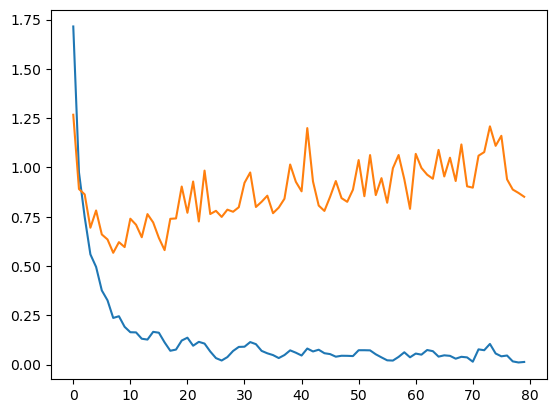

In [23]:

sns.lineplot(train_loss)
sns.lineplot(valid_loss)

<Axes: >

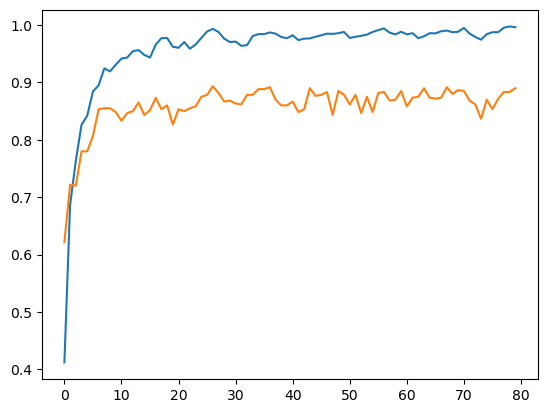

In [24]:

sns.lineplot(train_acc)
sns.lineplot(valid_acc)

In [25]:
valid_acc[-1]

0.89

In [26]:
train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [27]:
objects=[]
for i,j in zip(label_map,range(10)):
    objects.append(i)


In [28]:
valid=train[train['sign'].isin(objects)]

In [29]:
valid

,path,participant_id,sequence_id,sign
11,train_landmark_files/36257/1000536928.parquet,36257,1000536928,apple
50,train_landmark_files/61333/1002052130.parquet,61333,1002052130,TV
54,train_landmark_files/16069/1002113535.parquet,16069,1002113535,another
73,train_landmark_files/62590/1002885072.parquet,62590,1002885072,alligator
84,train_landmark_files/22343/1003347075.parquet,22343,1003347075,TV
...,...,...,...,...
94204,train_landmark_files/25571/988387855.parquet,25571,988387855,alligator
94212,train_landmark_files/28656/988744760.parquet,28656,988744760,arm
94235,train_landmark_files/34503/990124677.parquet,34503,990124677,alligator
94358,train_landmark_files/30680/994981668.parquet,30680,994981668,any


In [30]:
#data preprocessing
##subclass to pytorch nn model superclass
class FeatureGen(nn.Module):
    def __init__(self):
        super(FeatureGen,self).__init__()
        pass
    
    def forward(self,x):
        LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348]
        #extracting different landmarks
        face_x=x[:,LANDMARK_IDX,:].contiguous().view(-1,len(LANDMARK_IDX)*3) #-1 - infer from data
        lefth_x=x[:,468:489,:].contiguous().view(-1,21*3)
        pose_x=x[:,489:522,:].contiguous().view(-1,33*3)
        righth_x=x[:,522:,:].contiguous().view(-1,21*3)
        '''
        print("Dimension of face: ",face_x.shape)
        print("Dimension of lefth: ",lefth_x.shape)
        print("Dimension of pos: ",pose_x.shape)
        print("Dimension of right: ",righth_x.shape)
        print()
        '''
        
        #removing null values row-wise
        lefth_x=lefth_x[~torch.any(torch.isnan(lefth_x),dim=1),:]
        righth_x=righth_x[~torch.any(torch.isnan(righth_x),dim=1),:]
        '''
        print("Dimension of face: ",face_x.shape)
        print("Dimension of lefth: ",lefth_x.shape)
        print("Dimension of pos: ",pose_x.shape)
        print("Dimension of right: ",righth_x.shape)
        print()
       '''
        #extracting info about mean and std for landmarks column-wise hence 0
        x1m=torch.mean(face_x,axis=0)
        x2m=torch.mean(lefth_x,axis=0)
        x3m=torch.mean(pose_x,axis=0)
        x4m=torch.mean(righth_x,axis=0)
        '''
        print("Dimension of facemean: ",x1m.shape)
        print("Dimension of lefthmean: ",x2m.shape)
        print("Dimension of posmean: ",x3m.shape)
        print("Dimension of rightmean: ",x4m.shape)
        print()
        '''
        x1s=torch.std(face_x,0)
        x2s=torch.std(lefth_x,0)
        x3s=torch.std(pose_x,0)
        x4s=torch.std(righth_x,0)
        
        '''
        print("Dimension of facestd: ",x1s.shape)
        print("Dimension of leftstd: ",x2s.shape)
        print("Dimension of posstd: ",x3s.shape)
        print("Dimension of rightstd: ",x4s.shape)
        #raise Exception("Stop")
        '''
        #preparing final data with aggregated values
        
        xfeat=torch.cat([x1m,x2m,x3m,x4m, x1s,x2s,x3s,x4s], axis=0)
        xfeat=torch.where(torch.isnan(xfeat),torch.tensor(0.0, dtype=torch.float32),xfeat)
        
        
        return xfeat
    
feature_converter=FeatureGen()

In [31]:
ROWS_PER_FRAME = 543
#we are creating the training data
def load_relevant_data_subset(pq_path):
    #extracting necessary data and reshaping
    data_columns=['x', 'y', 'z']
    data=pd.read_parquet(pq_path,columns=data_columns)
    n_frames=int(len(data)/ROWS_PER_FRAME)
    data=data.values.reshape(n_frames,ROWS_PER_FRAME,len(data_columns))
    return data.astype(np.float32)

In [32]:
#the preparation of data to be fed into our model
#the first task to be accomplished
import multiprocessing as mp

#for every row
def convert_row(row):
    x = load_relevant_data_subset(os.path.join("/kaggle/input/asl-signs", row.path))
    x = feature_converter(torch.tensor(x)).cpu().numpy()
    return x,row.label

def convert_and_save_data():
    #labelling each sign with a unique number
    valid['label']=valid['sign'].map(label_map)
   
    #data and label holders
    npdata=np.zeros((valid.shape[0], 528))
    nplabels=np.zeros(valid.shape[0])
    
    for i,j in zip(range(valid.shape[0]),tqdm(range(valid.shape[0]))):
       
        npdata[i,:],nplabels[i]=convert_row(valid.iloc[i,:])
    np.save("feature_data.npy",npdata)
    np.save("feature_labels.npy",nplabels)
    
#to convert our data to a format that can be fed to our model
convert_and_save_data()

100%|█████████▉| 3712/3713 [01:16<00:00, 48.50it/s]


In [33]:
validx=np.load("/kaggle/working/feature_data.npy")
validy=np.load("/kaggle/working/feature_labels.npy")

In [34]:
validx=scaler.fit_transform(validx)

In [35]:
validx.shape

(3713, 528)

In [36]:
valid_data=ASLData(validx,validy)

In [37]:
val_loader=DataLoader(valid_data,batch_size=1,num_workers=4,shuffle=True)

In [38]:
val_correct=0
val_total=0
actual=[]
predictions=[]
for x,y in val_loader:
    x = torch.Tensor(x).float()
    y = torch.Tensor(y).long()
        
    with torch.no_grad():
        y_pred = model(x)
        loss = criterion(y_pred, y)
        val_loss_sum += loss.item()
        #print("Actual is:",y)
        actual.append(y.cpu().numpy()[0])
        predictions.append(np.argmax(y_pred.cpu().numpy(), axis=1)[0])
        #print("Predicted is:",np.sum((np.argmax(y_pred.cpu().numpy(), axis=1))))
        val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
        
        val_total += 1
    
        

In [39]:
val_correct

3242

In [40]:
val_total

3713

In [41]:
predictions=np.array(predictions)

In [42]:
actual=np.array(actual)

In [43]:
predictions==actual

array([ True,  True,  True, ...,  True,  True, False])

In [44]:
predictions

array([8, 9, 6, ..., 7, 8, 6])

In [45]:
actual

array([8, 9, 6, ..., 7, 8, 7])